# Modelltraining Lokalisierung von 3 Verkehrsschildern pro Bild

## Bearbeiter
**TINF19-IT2**  
Patrick Küsters (9815596)  
Nick Kramer (3122448)  
**TINF19-IT1**  
Sören Holzenkamp (8528927)

## Imports
Lokal entwickelte Skripte und Module

In [1]:
import sys
from pathlib import Path
module_path = str(Path.cwd() / "src")
if module_path not in sys.path:
    sys.path.append(module_path)
from reader import Reader
from display_data import ImageDisplayer
from image_detection import predict_and_display_img
from evaluation import plot_confusion_matrix
import collage

Externe Bibliotheken

In [2]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AvgPool2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from skimage import exposure, transform
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import mimetypes
import pickle
import cv2
import os

In [3]:
file = open(r"./pickle/data_3.pickle", 'rb')
data = pickle.load(file)
file.close()
file = open(r"./pickle/labels_3.pickle", 'rb')
labels = pickle.load(file)
file.close()

In [4]:
#cv2.namedWindow("test", cv2.WINDOW_NORMAL)
#cv2.imshow("test", data[5])
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [4]:
targets = []
input_shape = data[0].shape
for k in labels:
    a = list(k.keys())
    a.sort(key=lambda x: (x[0], x[1])) # !!!
    temp = [] #input vektor for model
    for e in a:
        x1, y1, x2, y2 = e #extract coordinates
        h, w = input_shape[:2]
        temp.append(x1/w) #scale with image shape
        temp.append(y1/h)
        temp.append(x2/w)
        temp.append(y2/h)
    targets.append(temp)
    
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

In [5]:
split = train_test_split(data, targets, test_size=0.25, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]

split = train_test_split(testImages, testTargets, test_size=0.5, random_state=42)

(validationImages, testImages) = split[:2]
(validationTargets, testTargets) = split[2:4]

In [6]:
input_layer = Input(input_shape)

#create the base layers
base_layers = Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(input_layer)
base_layers = MaxPooling2D(name='bl_3')(base_layers)
base_layers = Conv2D(24, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = MaxPooling2D(name='bl_5')(base_layers)
base_layers = Conv2D(32, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = MaxPooling2D(name='bl_7')(base_layers)
base_layers = Conv2D(48, 3, padding='same', activation='relu', name='bl_8')(base_layers)
base_layers = MaxPooling2D(name='bl_9')(base_layers)
base_layers = Conv2D(64, 3, padding='same', activation='relu', name='bl_10')(base_layers)
base_layers = MaxPooling2D(name='bl_11')(base_layers)
base_layers = Conv2D(96, 3, padding='same', activation='relu', name='bl_12')(base_layers)
base_layers = MaxPooling2D(name='bl_13')(base_layers)
base_layers = Conv2D(128, 3, padding='same', activation='relu', name='bl_14')(base_layers)
base_layers = MaxPooling2D(name='bl_15')(base_layers)
base_layers = Flatten(name='bl_18')(base_layers)

#create the localiser branch
locator_branch = Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = Dense(96, activation='relu', name='bb_2')(locator_branch)
locator_branch = Dense(64, activation='relu', name='bb_3')(locator_branch)
locator_branch = Dense(48, activation='relu', name='bb_4')(locator_branch)
locator_branch = Dense(32, activation='relu', name='bb_5')(locator_branch)
locator_branch = Dense(16, activation='relu', name='bb_6')(locator_branch)
locator_branch = Dense(12, activation='sigmoid', name='bb_head')(locator_branch)

model = tf.keras.Model(input_layer, outputs=locator_branch)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 192, 3)]     0         
                                                                 
 bl_2 (Conv2D)               (None, 128, 192, 16)      448       
                                                                 
 bl_3 (MaxPooling2D)         (None, 64, 96, 16)        0         
                                                                 
 bl_4 (Conv2D)               (None, 64, 96, 24)        3480      
                                                                 
 bl_5 (MaxPooling2D)         (None, 32, 48, 24)        0         
                                                                 
 bl_6 (Conv2D)               (None, 32, 48, 32)        6944      
                                                                 
 bl_7 (MaxPooling2D)         (None, 16, 24, 32)        0     

2022-03-23 03:43:53.527613: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
loss = tf.keras.losses.MAE

In [8]:
model.compile(loss=loss, optimizer='Adam')

In [9]:
epoch_num = 20

In [10]:
training = model.fit(trainImages, trainTargets,
             validation_data=(testImages, testTargets),
             batch_size=10,
             epochs=epoch_num,
             shuffle=True,
             verbose=1)

2022-03-23 03:43:53.710587: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4423680000 exceeds 10% of free system memory.


Epoch 1/20
1500/1500 [==============================] - ETA: 0s - loss: 0.1530

2022-03-23 03:49:06.013573: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 737280000 exceeds 10% of free system memory.


1500/1500 [==============================] - 317s 211ms/step - loss: 0.1530 - val_loss: 0.0982
Epoch 2/20
1500/1500 [==============================] - 206s 137ms/step - loss: 0.0736 - val_loss: 0.0598
Epoch 3/20
1500/1500 [==============================] - 221s 147ms/step - loss: 0.0517 - val_loss: 0.0489
Epoch 4/20
1500/1500 [==============================] - 190s 127ms/step - loss: 0.0449 - val_loss: 0.0461
Epoch 5/20
1500/1500 [==============================] - 190s 127ms/step - loss: 0.0399 - val_loss: 0.0425
Epoch 6/20
1500/1500 [==============================] - 163s 109ms/step - loss: 0.0365 - val_loss: 0.0370
Epoch 7/20
1500/1500 [==============================] - 149s 99ms/step - loss: 0.0333 - val_loss: 0.0371
Epoch 8/20
1500/1500 [==============================] - 149s 99ms/step - loss: 0.0309 - val_loss: 0.0330
Epoch 9/20
1500/1500 [==============================] - 149s 100ms/step - loss: 0.0286 - val_loss: 0.0337
Epoch 10/20
1500/1500 [==============================] - 14

In [11]:
model.save(r"./models/regr_3signs_2.pickle", save_format="h5")

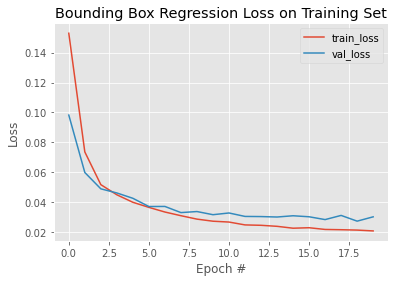

In [12]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epoch_num), training.history["loss"], label="train_loss")
plt.plot(np.arange(0, epoch_num), training.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
#plt.show()
plt.savefig('./images/training3_20_1.png')